In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Helpful functions

In [ ]:
#--------------------------  helpful functions ---------------------------------

# WaveletSmooth
def waveletSmooth( x, wavelet="db4", level=1, DecLvl=2, title=None):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=DecLvl )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

def prepare_data_lstm(data, labels, time_steps, train=False):
    X, Y = [], []
    # Assuming data is a 2D numpy array where rows are time points and columns are features
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        Y.append(labels[i])

    X, Y = np.array(X), np.array(Y)

    if train:
        # Shuffle the data for training
        shuffle_indices = np.arange(X.shape[0])
        np.random.shuffle(shuffle_indices)
        X = X[shuffle_indices]
        Y = Y[shuffle_indices]

    return X, Y

def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / ss_tot


def strategy_return(true_price,predict_price):
  own = 0 #No store
  sum = 10000
  share = 0
  for i in range(len(predict_price)-1):
    if own == 0:

      if predict_price[i+1]> predict_price[i]+1:
        share = sum/true_price[i]
        sum = 0
        own = 1
    if own == 1:
      if predict_price[i+1]< predict_price[i]-1:
        sum = share*true_price[i]
        share = 0
        own = 0

  sum += share*true_price[-1]
  rate = (sum-10000)/10000
  return rate

# Some preparations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from statsmodels.robust import mad

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import Model
from scipy.stats import pearsonr

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/DL final/processed_data.xlsx", index_col=0)

In [ ]:
df = df.iloc[::-1]
df

Open        High         Low       Close     Volume  \
2016-01-04  200.490005  201.029999  198.589996  201.020004  222353500   
2016-01-05  201.399994  201.899994  200.050003  201.360001  110845800   
2016-01-06  198.339996  200.059998  197.600006  198.820007  152112600   
2016-01-07  195.330002  197.440002  193.589996  194.050003  213436100   
2016-01-08  195.190002  195.850006  191.580002  191.919998  209817200   
...                ...         ...         ...         ...        ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994   67126600   
2023-12-26  474.070007  476.579987  473.989990  475.649994   55387000   
2023-12-27  475.440002  476.660004  474.890015  476.510010   68000300   
2023-12-28  476.880005  477.549988  476.260010  476.690002   77158100   
2023-12-29  476.489990  477.029999  473.299988  475.309998  122234100   

                SMA5     SMA10     EMA15     WMA20    MACD  ...       CCI  \
2016-01-04  177.2013  176.6139  176.9366  176.7338 -0.6834  ... -118.7786   
2016-01-05  176.6026  176.4953  176.5998  176.4913 -0.7245  ...  -92.0178   
2016-01-06  175.1889  176.2297  175.9742  176.0090 -1.0323  ... -138.3142   
2016-01-07  173.1506  175.5904  175.1013  175.3183 -1.1309  ... -158.9920   
2016-01-08  171.4307  174.7685  174.3224  174.6570 -1.1471  ... -141.6137   
...              ...       ...       ...       ...     ...  ...       ...   
2023-12-22  471.0584  466.8339  463.7376  463.9838  7.3457  ...   84.0948   
2023-12-26  471.6744  468.4528  464.8443  465.1978  7.9023  ...  114.1785   
2023-12-27  472.2546  470.0156  465.9834  466.4409  8.5136  ...  118.8602   
2023-12-28  472.8368  471.4380  467.1596  467.7107  9.0160  ...  114.0942   
2023-12-29  473.8656  472.0263  468.1402  468.8409  9.4417  ...   56.3871   

               ROC          OBV      BOLL     ATR  TREASURY5  TREASURY30  \
2016-01-04 -1.2801  13035604607  176.7840  2.3498       1.73        2.98   
2016-01-05  0.6699  13146450407  176.4813  2.2748       1.73        3.01   
2016-01-06 -1.4132  12994337807  176.1233  2.3726       1.65        2.94   
2016-01-07 -4.6437  12780901707  175.6192  2.5879       1.61        2.92   
2016-01-08 -6.8440  12571084507  175.0922  2.6985       1.57        2.91   
...            ...          ...       ...     ...        ...         ...   
2023-12-22  3.3406  16268656546  460.5255  4.2123       3.87        4.05   
2023-12-26  3.3749  16324043498  461.6723  4.0832       3.89        4.04   
2023-12-27  3.0910  16387917894  462.8396  3.8513       3.78        3.95   
2023-12-28  1.7271  16465076010  464.0319  3.5948       3.83        3.98   
2023-12-29  1.1081  16342792861  465.0664  3.6071       3.84        4.03   

            Interest Rate    USUK   USCNY  
2016-01-04           0.36  1.4748  6.5084  
2016-01-05           0.36  1.4712  6.5210  
2016-01-06           0.36  1.4675  6.5271  
2016-01-07           0.36  1.4630  6.5823  
2016-01-08           0.36  1.4617  6.5686  
...                   ...     ...     ...  
2023-12-22           5.33  1.2687  7.1431  
2023-12-26           5.33  1.2693  7.1363  
2023-12-27           5.33  1.2719  7.1456  
2023-12-28           5.33  1.2797  7.1311  
2023-12-29           5.33  1.2731  7.0880  

[2006 rows x 23 columns]

In [ ]:
# 1 year of data
num_datapoints = 300
# roll by approx. 20 days - 1 months of trading days
step_size = 21
# calculate number of iterations we can do over the entire data set
num_iterations = int(np.ceil((len(df)-num_datapoints)/step_size))+2
print(num_iterations)

84


# Main code
The whole program is a large loop to fulfil the sliding window method.

This is 1 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_99 (SimpleRNN)   (None, 4, 50)             3700      
                                                                 
 dropout_99 (Dropout)        (None, 4, 50)             0         
                                                                 
 simple_rnn_100 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_100 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_101 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_101 (Dropout)       (None, 15)                0         
                                                                 
 dense_33 (Dense)            (None, 1)               

1/1 [==============================] - 0s 28ms/step - loss: 0.0215


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

This is 2 group of data has:(300, 23)
1/1 [==============================] - 0s 43ms/step - loss: 0.0126
This is 3 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0155
This is 4 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 28ms/step - loss: 0.0166
This is 5 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_102 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_102 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_103 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_103 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_104 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_104 (Dropout)       (None, 15)                0         
                                                                 
 dense_34 (Dense)            (None, 1)               

1/1 [==============================] - 0s 27ms/step - loss: 0.0224


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

This is 6 group of data has:(300, 23)
1/1 [==============================] - 0s 28ms/step - loss: 0.0033
This is 7 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0107
This is 8 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0137
This is 9 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_105 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_105 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_106 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_106 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_107 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_107 (Dropout)       (None, 15)                0         
                                                                 
 dense_35 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0265
This is 11 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0210
This is 12 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 28ms/step - loss: 0.0290
This is 13 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_108 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_108 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_109 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_109 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_110 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_110 (Dropout)       (None, 15)                0         
                                                                 
 dense_36 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0264
This is 15 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 46ms/step - loss: 0.0112
This is 16 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0068
This is 17 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_111 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_111 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_112 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_112 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_113 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_113 (Dropout)       (None, 15)                0         
                                                                 
 dense_37 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0167
This is 19 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0103
This is 20 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0290
This is 21 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_114 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_114 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_115 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_115 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_116 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_116 (Dropout)       (None, 15)                0         
                                                                 
 dense_38 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0157
This is 23 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0235
This is 24 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0072
This is 25 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_117 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_117 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_118 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_118 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_119 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_119 (Dropout)       (None, 15)                0         
                                                                 
 dense_39 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0050
This is 27 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 37ms/step - loss: 0.0110
This is 28 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 25ms/step - loss: 0.0259
This is 29 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_120 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_120 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_121 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_121 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_122 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_122 (Dropout)       (None, 15)                0         
                                                                 
 dense_40 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0153
This is 31 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 50ms/step - loss: 0.0199
This is 32 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0069
This is 33 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_123 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_123 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_124 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_124 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_125 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_125 (Dropout)       (None, 15)                0         
                                                                 
 dense_41 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 48ms/step - loss: 0.0123
This is 35 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0387
This is 36 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 36ms/step - loss: 0.0379
This is 37 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_126 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_126 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_127 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_127 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_128 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_128 (Dropout)       (None, 15)                0         
                                                                 
 dense_42 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0276
This is 39 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 41ms/step - loss: 0.0361
This is 40 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0179
This is 41 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_129 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_129 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_130 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_130 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_131 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_131 (Dropout)       (None, 15)                0         
                                                                 
 dense_43 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 28ms/step - loss: 0.0274
This is 43 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0066
This is 44 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0308
This is 45 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_132 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_132 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_133 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_133 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_134 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_134 (Dropout)       (None, 15)                0         
                                                                 
 dense_44 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0238
This is 47 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 45ms/step - loss: 0.0339
This is 48 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0350
This is 49 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_135 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_135 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_136 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_136 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_137 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_137 (Dropout)       (None, 15)                0         
                                                                 
 dense_45 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 35ms/step - loss: 0.0546
This is 51 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0415
This is 52 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 32ms/step - loss: 0.0157
This is 53 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_138 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_138 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_139 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_139 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_140 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_140 (Dropout)       (None, 15)                0         
                                                                 
 dense_46 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0061
This is 55 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 43ms/step - loss: 0.0037
This is 56 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0161
This is 57 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_141 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_141 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_142 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_142 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_143 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_143 (Dropout)       (None, 15)                0         
                                                                 
 dense_47 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0385
This is 59 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 28ms/step - loss: 0.0165
This is 60 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0329
This is 61 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_144 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_144 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_145 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_145 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_146 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_146 (Dropout)       (None, 15)                0         
                                                                 
 dense_48 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0086
This is 63 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 34ms/step - loss: 0.0239
This is 64 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0190
This is 65 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_147 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_147 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_148 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_148 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_149 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_149 (Dropout)       (None, 15)                0         
                                                                 
 dense_49 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 29ms/step - loss: 0.0106
This is 67 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 35ms/step - loss: 0.0094
This is 68 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0110
This is 69 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_150 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_150 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_151 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_151 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_152 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_152 (Dropout)       (None, 15)                0         
                                                                 
 dense_50 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0164
This is 71 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 30ms/step - loss: 0.0070
This is 72 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0141
This is 73 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_153 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_153 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_154 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_154 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_155 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_155 (Dropout)       (None, 15)                0         
                                                                 
 dense_51 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 28ms/step - loss: 0.0081
This is 75 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0161
This is 76 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 31ms/step - loss: 0.0303
This is 77 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_156 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_156 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_157 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_157 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_158 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_158 (Dropout)       (None, 15)                0         
                                                                 
 dense_52 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 26ms/step - loss: 0.0328
This is 79 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 37ms/step - loss: 0.0357
This is 80 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0479
This is 81 group of data has:(300, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_159 (SimpleRNN)  (None, 4, 50)             3700      
                                                                 
 dropout_159 (Dropout)       (None, 4, 50)             0         
                                                                 
 simple_rnn_160 (SimpleRNN)  (None, 4, 30)             2430      
                                                                 
 dropout_160 (Dropout)       (None, 4, 30)             0         
                                                                 
 simple_rnn_161 (SimpleRNN)  (None, 15)                690       
                                                                 
 dropout_161 (Dropout)       (None, 15)                0         
                                                                 
 dense_53 (Dense)            (None, 1)               

<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0051
This is 83 group of data has:(284, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0224
This is 84 group of data has:(263, 23)


<ipython-input-64-8a93c581b4c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["High"].loc[:] = feats["High"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
<ipython-input-64-8a93c581b4c1>:15: SettingWithC

1/1 [==============================] - 0s 27ms/step - loss: 0.0097


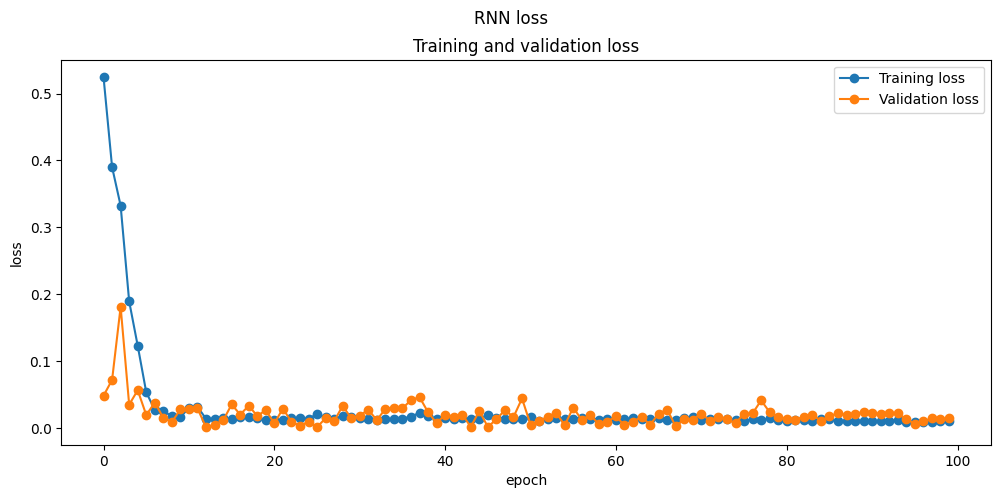

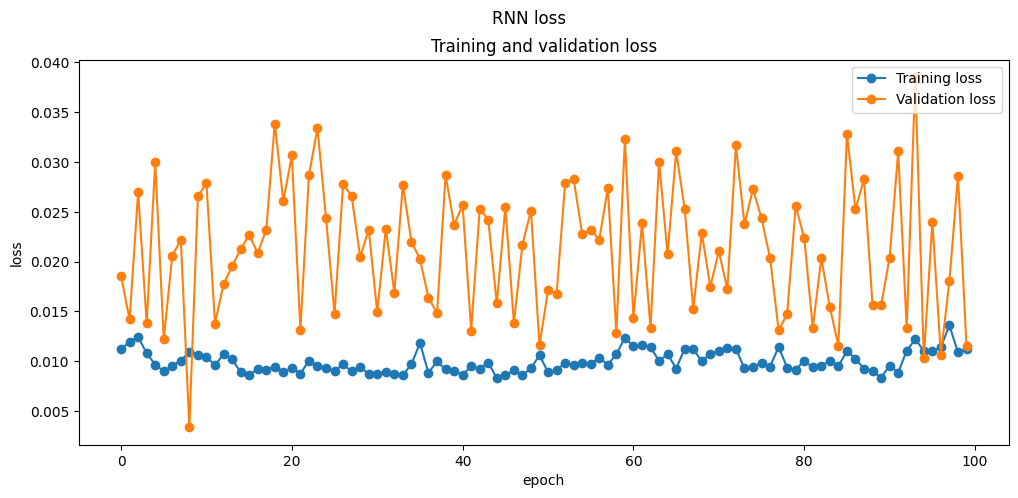

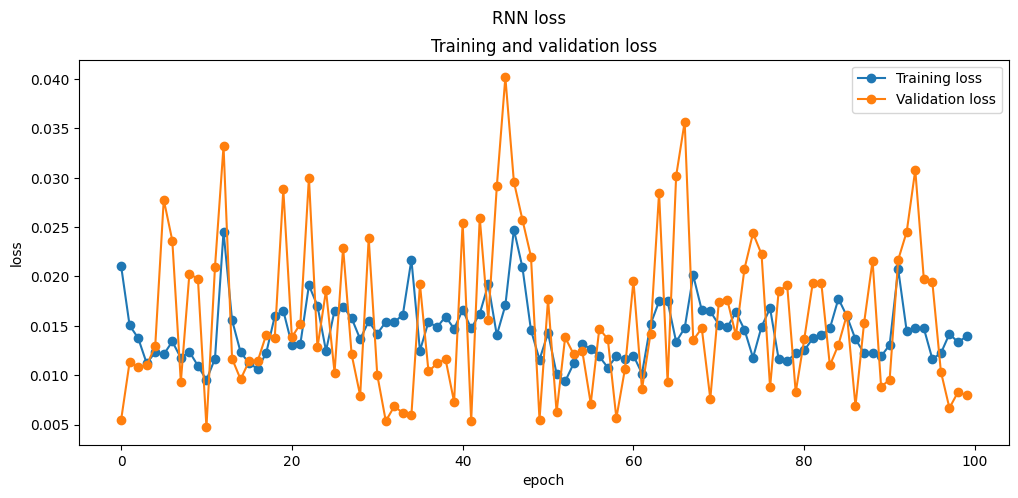

In [ ]:
pred = []
test_loss_RNN = []
test_r_RNN = []
for n in range(num_iterations):
  data = df.iloc[n*step_size:num_datapoints+n*step_size,:].copy()
  data.columns = [col.strip() for col in data.columns.tolist()]
  feats = data
  print("This is " +str(n+1) + " group of data has:"+str(feats.shape))


  # This is a scaling of the inputs such that they are in an appropriate range
  feats["Open"].loc[:] = feats["Open"].loc[:]/1000
  feats["High"].loc[:] = feats["High"].loc[:]/1000
  feats["Low"].loc[:] = feats["Low"].loc[:]/1000
  feats["Close"].loc[:] = feats["Close"].loc[:]/1000
  feats["Volume"].loc[:] = feats["Volume"].loc[:]/100000000
  feats["SMA5"].loc[:] = feats["SMA5"].loc[:]/1000
  feats["SMA10"].loc[:] = feats["SMA10"].loc[:]/1000
  feats["EMA15"].loc[:] = feats["EMA15"].loc[:]/1000
  feats["WMA20"].loc[:] = feats["WMA20"].loc[:]/1000
  feats["MACD"].loc[:] = feats["MACD"].loc[:]/10
  feats["ADX"].loc[:] = feats["ADX"].loc[:]/100
  feats["STOCH"].loc[:] = feats["STOCH"].loc[:]/100
  feats["RSI"].loc[:] = feats["RSI"].loc[:]/100
  feats["CCI"].loc[:] = feats["CCI"].loc[:]/100
  feats["ROC"].loc[:] = feats["ROC"].loc[:]/10
  feats["OBV"].loc[:] = feats["ROC"].loc[:]/10000000000
  feats["BOLL"].loc[:] = feats["BOLL"].loc[:]/1000
  feats["ATR"].loc[:] = feats["ATR"].loc[:]/10
  feats["TREASURY5"].loc[:] = feats["TREASURY5"].loc[:]/10
  feats["TREASURY30"].loc[:] = feats["TREASURY30"].loc[:]/10
  feats["Interest Rate"].loc[:] = feats["Interest Rate"].loc[:]/10
  feats["USUK"].loc[:] = feats["USUK"].loc[:]/10
  feats["USCNY"].loc[:] = feats["USCNY"].loc[:]/10


  data_close = feats['Close'].copy()
  data_close_new = data_close


  # Split in train, test and validation set
  test = feats[-step_size:]
  validate = feats[-2*step_size:-step_size]
  train = feats[:-2*step_size]

  # target
  y_test = data_close_new[-step_size:].to_numpy()
  y_validate = data_close_new[-2*step_size:-step_size].to_numpy()
  y_train = data_close_new[:-2*step_size].to_numpy()

  # variables
  feats_train = train.to_numpy().astype(np.float64)
  feats_validate = validate.to_numpy().astype(np.float64)
  feats_test = test.to_numpy().astype(np.float64)

  # data_close = pd.Series(np.concatenate((y_train,y_validate,y_test)))

  feats_norm_train = feats_train.copy()
  feats_norm_validate = feats_validate.copy()
  feats_norm_test = feats_test.copy()

  # ---------------------------------------------------------------------------
  # ----------------------- STEP 1: DENOISE USING DWT -----------------------
  # ---------------------------------------------------------------------------
  # This is for training set
  for i in range(feats_norm_train.shape[1]):
    feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
  # for the validation we have to do the transform using training data + the current and past validation data
  # i.e. we CAN'T USE all the validation data because we would then look into the future
  temp = np.copy(feats_norm_train)
  feats_norm_validate_WT = np.copy(feats_norm_validate)
  for j in range(feats_norm_validate.shape[0]):
    #concatenate train with the latest validation sample
    temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
    for i in range(feats_norm_validate.shape[1]):
      feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]


  # for the test we have to do the transform using training data + validation data + current and past test data
  temp_train = np.copy(feats_norm_train)
  temp_val = np.copy(feats_norm_validate)
  temp = np.concatenate((temp_train, temp_val))
  feats_norm_test_WT = np.copy(feats_norm_test)
  for j in range(feats_norm_test.shape[0]):
    #concatenate train and validation data with the latest test sample
    temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
    for i in range(feats_norm_test.shape[1]):
      feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

  data_close = waveletSmooth(data_close,level=1)
  # ---------------------------------------------------------------------------
  # -------------------- STEP 2: PREPARE TIME-SERIES for lstm --------------------------
  # ---------------------------------------------------------------------------


  # split the entire training time-series into pieces, depending on the number
  # of time steps for the LSTM

  time_steps = 4
  args = (feats_norm_train,feats_norm_validate_WT,feats_norm_test_WT)
  x_concat = np.concatenate(args)

  validate_extra = np.concatenate((feats_norm_train[-time_steps:], feats_norm_validate_WT))
  test_extra = np.concatenate((feats_norm_validate_WT[-time_steps:], feats_norm_test_WT))

  y_train_input = data_close[:-len(feats_norm_validate_WT)-len(feats_norm_test_WT)]
  y_val_input = data_close[-len(feats_norm_test_WT)-len(feats_norm_validate_WT)-4:-len(feats_norm_test_WT)]
  y_test_input = data_close[-len(feats_norm_test_WT)-4:]

  x, y = prepare_data_lstm(feats_norm_train, y_train_input, time_steps)
  x_v, y_v = prepare_data_lstm(validate_extra, y_val_input, time_steps)
  x_te, y_te = prepare_data_lstm(test_extra, y_test_input, time_steps)


  x_test = x_te
  x_validate = x_v
  x_train = x

  y_train = y
  y_validate = y_v
  y_test = y_te

  # ---------------------------------------------------------------------------
  # -------------------- STEP 3: RNN --------------------------
  # ---------------------------------------------------------------------------

  if n%4 ==0:

    # Get time step and features number
    timestamp = x_train.shape[1]
    features = x_train.shape[2]

    model3 = keras.Sequential()
    model3.add(keras.layers.SimpleRNN(units=50, return_sequences=True, input_shape=(timestamp, 23)))
    model3.add(keras.layers.Dropout(0.2))
    model3.add(keras.layers.SimpleRNN(units=30, return_sequences=True))
    model3.add(keras.layers.Dropout(0.2))
    model3.add(keras.layers.SimpleRNN(units=15))
    model3.add(keras.layers.Dropout(0.2))
    model3.add(keras.layers.Dense(units=1))

    model3.summary()


    model3.compile(loss='mae', optimizer = Adam(learning_rate = 0.01))


  history3 = model3.fit(x_train,y_train, epochs=100, batch_size=10,verbose=0, validation_data=(x_validate,y_validate))


  if n==0 or n==1 or n==83 :
    # training and validation loss
    f, (ax1) = plt.subplots(1, figsize=(12, 5))
    ax1.plot(history3.history['loss'],'-o', label='Training loss')
    ax1.plot(history3.history['val_loss'],'-o', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper right')

    f.suptitle('RNN loss')

  predict_test = model3.predict(x_test)
  pred.append(predict_test)
  test_loss = model3.evaluate(x_test,y_test)
  r,_ = pearsonr(predict_test.flatten(),y_test)


  test_loss_RNN.append(test_loss)
  test_r_RNN.append(r)


combined_array = np.vstack(pred)


In [ ]:
combined_array = combined_array[:1727]
combined_array.shape

(1727, 1)

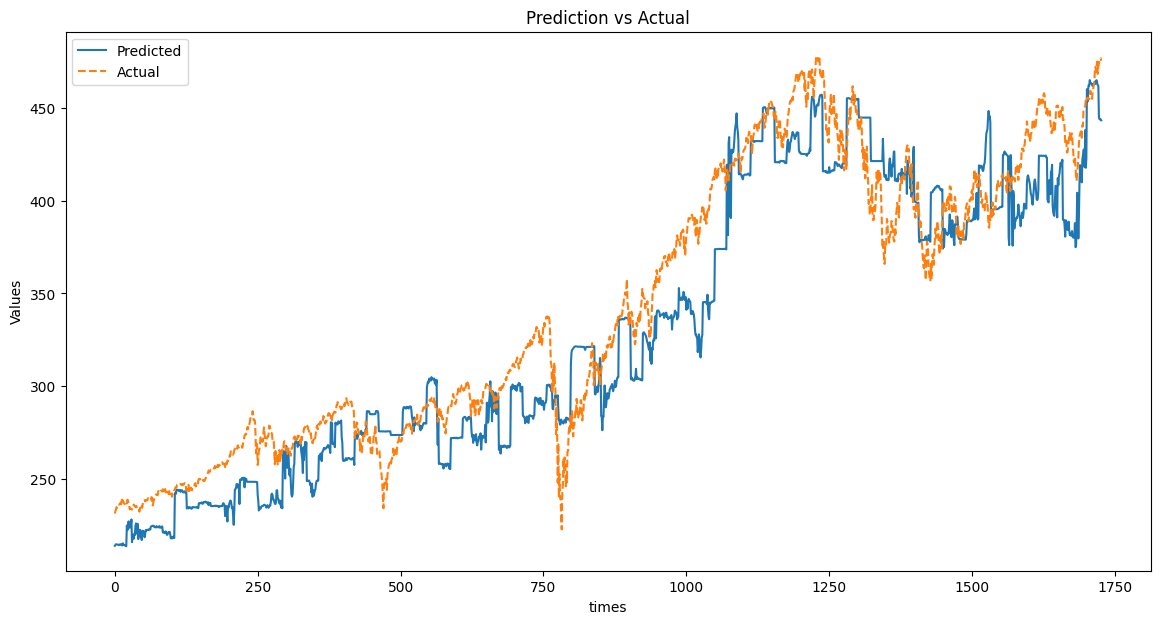

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(combined_array*1000, label='Predicted')
plt.plot(df['Close'][279:279+len(combined_array)].to_numpy(), label='Actual', linestyle='--')
plt.title('Prediction vs Actual')
plt.ylabel('Values')
plt.xlabel('times')
plt.legend()
plt.show()

In [ ]:
y_test = df['Close'][279:279+len(combined_array)].to_numpy()
y_test_true = y_test.reshape(len(combined_array),1)
strategy_return(y_test_true,combined_array*1000)

array([0.77259288])

## Return rate

In [ ]:
averages_return_per_year = [strategy_return(y_test_true[i:i+252],combined_array[i:i+252]*1000) for i in range(0,len(combined_array),252)]
averages_return_per_year

[array([0.06374421]),
 array([-0.04670659]),
 array([0.13362559]),
 array([0.33917395]),
 array([0.17497238]),
 array([-0.0940134]),
 array([0.11988373])]

## R

In [ ]:
averages_r_per_year = [sum(test_r_RNN[i:i+12]) / 12 for i in range(0, len(test_r_RNN), 12)]
averages_r_per_year

[0.1523341074009796,
 0.39773124217437683,
 0.20085701567012668,
 0.25732601179489734,
 0.22939687472170467,
 0.07563216464532088,
 0.2547743790728016]

## MAE(loss)

In [ ]:
averages_loss_per_year = [sum(test_loss_RNN[i:i+12]) / 12 for i in range(0, len(test_loss_RNN), 12)]
averages_loss_per_year

[0.017817685516395915,
 0.01793385318402822,
 0.01998252033566435,
 0.024693683992760878,
 0.026727200446960826,
 0.01661423364809404,
 0.0247739969054237]